### 用維吉尼亞市的OHCA數據訓練SVR模型

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3


In [24]:

h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# 正規化數據 (將特徵縮放到相同範圍，以提高模型的穩定性)
scaler = StandardScaler()
normalized_spatial_data = scaler.fit_transform(h3_spatial_data)

# 設定 SVR 參數
kernel = 'linear'  # 指定核函數
C = 1  # 指定 C 參數
epsilon = 0.05  # 指定 epsilon 參數

# 初始化 SVR 模型
svr = SVR(kernel=kernel, C=C, epsilon=epsilon)

# 訓練模型
svr.fit(X_train_reguli, y_train_reguli)

# 進行預測並評估表現 (轉換回原始尺度)
y_pred_train = svr.predict(X_train_reguli) * ohca_reguli_inverse
y_pred_test = svr.predict(X_test_reguli) * ohca_reguli_inverse


# 計算 MAE (平均絕對誤差) 和 R² (決定係數)
mae_train = mean_absolute_error(y_train_reguli * ohca_reguli_inverse, y_pred_train)
mae_test = mean_absolute_error(y_test_reguli * ohca_reguli_inverse, y_pred_test)

r2_train = r2_score(y_train_reguli * ohca_reguli_inverse, y_pred_train)
r2_test = r2_score(y_test_reguli * ohca_reguli_inverse, y_pred_test)


# 輸出結果
print(f"Kernel: {kernel}")
print(f"C: {C}")
print(f"Epsilon: {epsilon}")
print(f"MAE (Train): {mae_train}")
print(f"MAE (Test): {mae_test}")
print(f"R² (Train): {r2_train}")
print(f"R² (Test): {r2_test}")



Kernel: linear
C: 1
Epsilon: 0.05
MAE (Train): 2.155442200780529
MAE (Test): 5.9113057370852164
R² (Train): 0.9567643526560218
R² (Test): 0.7306680741512512


### SVR with 宜興市 dataset

In [25]:
h3_l7_df_yixing = pd.read_csv('h3_l7_df_yixing.csv')
h3_l7_df_yixing

yixing_data = h3_l7_df_yixing.copy()

feature_cols = [col for col in h3_spatial_data.columns if col != 'ohca']

# 取得訓練集的 Min 和 Max (只針對特徵欄位)
train_min_vec = h3_spatial_data[feature_cols].min()
train_max_vec = h3_spatial_data[feature_cols].max()

X_yixing = yixing_data[feature_cols]

# 使用「訓練集」的 min/max 進行正規化公式： (x - min) / (max - min)
X_yixing_normalized = (X_yixing - train_min_vec) / (train_max_vec - train_min_vec)

# 轉換為模型需要的 numpy array 格式 (float64)
X_yixing_input = np.array(X_yixing_normalized).astype(np.float64)

y_pred_yixing_norm = svr.predict(X_yixing_input)
y_pred_yixing_final = y_pred_yixing_norm * ohca_reguli_inverse

result_df = pd.DataFrame({
    'id': h3_l7_df_yixing['id'],
    'predicted_ohca': y_pred_yixing_final
})

print("預測完成！前 5 筆預測結果：")
print(result_df.head(55))

預測完成！前 5 筆預測結果：
                 id  predicted_ohca
0   87309e000ffffff        1.970979
1   87309e001ffffff        3.065422
2   87309e002ffffff        1.583586
3   87309e003ffffff        0.269388
4   87309e004ffffff       40.444456
5   87309e005ffffff        1.595352
6   87309e006ffffff        0.292692
7   87309e008ffffff        0.510205
8   87309e009ffffff        1.189760
9   87309e00bffffff       -1.672827
10  87309e00cffffff        1.843547
11  87309e00dffffff        0.362407
12  87309e00effffff       -1.403036
13  87309e010ffffff       -5.002815
14  87309e011ffffff       10.729206
15  87309e012ffffff       21.132959
16  87309e013ffffff       -0.402700
17  87309e014ffffff       82.531152
18  87309e015ffffff        4.583232
19  87309e016ffffff        2.813807
20  87309e018ffffff       -7.489695
21  87309e019ffffff       -1.862140
22  87309e01bffffff        0.407323
23  87309e01cffffff        1.657220
24  87309e01dffffff       -0.724722
25  87309e01effffff       10.143899
26  87309e02

### 宜興市預測結果

繪圖數據範圍: Min=-12.1192, Max=451.2331


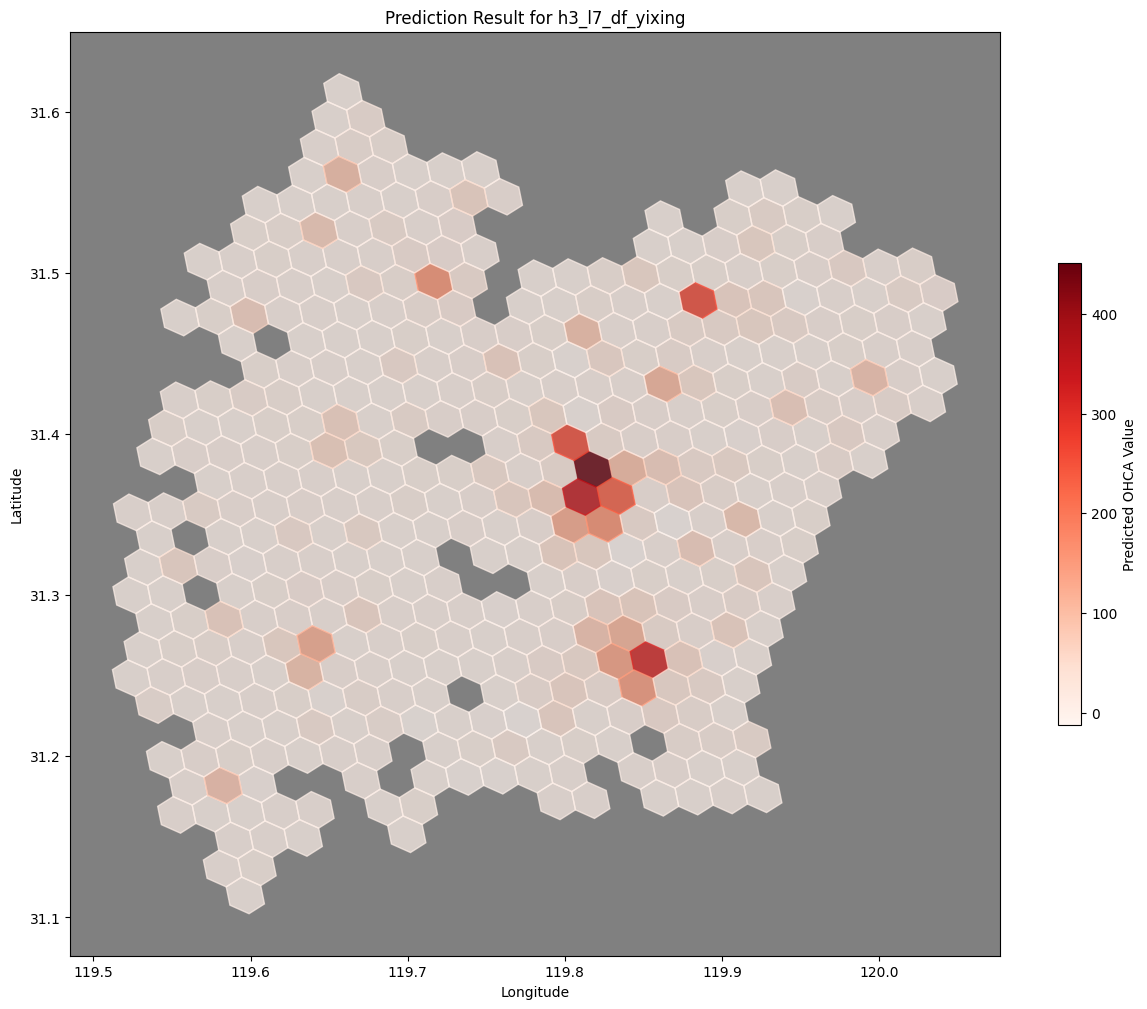

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Polygon
import h3

# ---------------------------------------------------------
# Step 1: 準備繪圖資料
# ---------------------------------------------------------
# 將原本的 ID 與 剛剛算出來的預測值 (y_pred_yixing_final) 結合
visualization_df = pd.DataFrame({
    'id': h3_l7_df_yixing['id'],      # 確保這裡是來自 yixing 資料集的 ID
    'pred_value': y_pred_yixing_final # 這是剛剛算出來的預測結果
})

# 定義顏色範圍 (vmin, vmax)
# 使用這次預測結果的最大最小值，讓顏色分布最明顯
vmin_val = visualization_df['pred_value'].min()
vmax_val = visualization_df['pred_value'].max()

print(f"繪圖數據範圍: Min={vmin_val:.4f}, Max={vmax_val:.4f}")

# ---------------------------------------------------------
# Step 2: 開始繪圖
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 12))

# 建立顏色映射 (Normalize)
color_norm = mcolors.Normalize(vmin=vmin_val, vmax=vmax_val)

# Step 3: 繪製每個網格
# 注意：如果數據量很大，這個迴圈可能會跑一點時間
for index, row in visualization_df.iterrows():
    # 將 H3 索引轉換為多邊形邊界 (geo_json=True 確保輸出格式為 (lng, lat))
    try:
        boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
        polygon = Polygon(boundary)
        
        # 根據預測值決定顏色
        color = plt.cm.Reds(color_norm(row['pred_value']))
        
        # 畫在圖上
        ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)
    except Exception as e:
        print(f"Error plotting H3 ID {row['id']}: {e}")
        continue

# Step 4: 創建並顯示顏色條
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=color_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Predicted OHCA Value') # 設定 Colorbar 標籤

# Step 5: 設定地圖細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Prediction Result for h3_l7_df_yixing') # 設定標題
ax.set_facecolor('grey') # 設定背景色，讓紅色更明顯

# 自動調整顯示範圍以適應所有多邊形
ax.autoscale_view()

# 顯示地圖
plt.show()

# 如果想存檔，可以取消下面這行的註解
# fig.savefig('Prediction_Result_yixing.png', dpi=300)

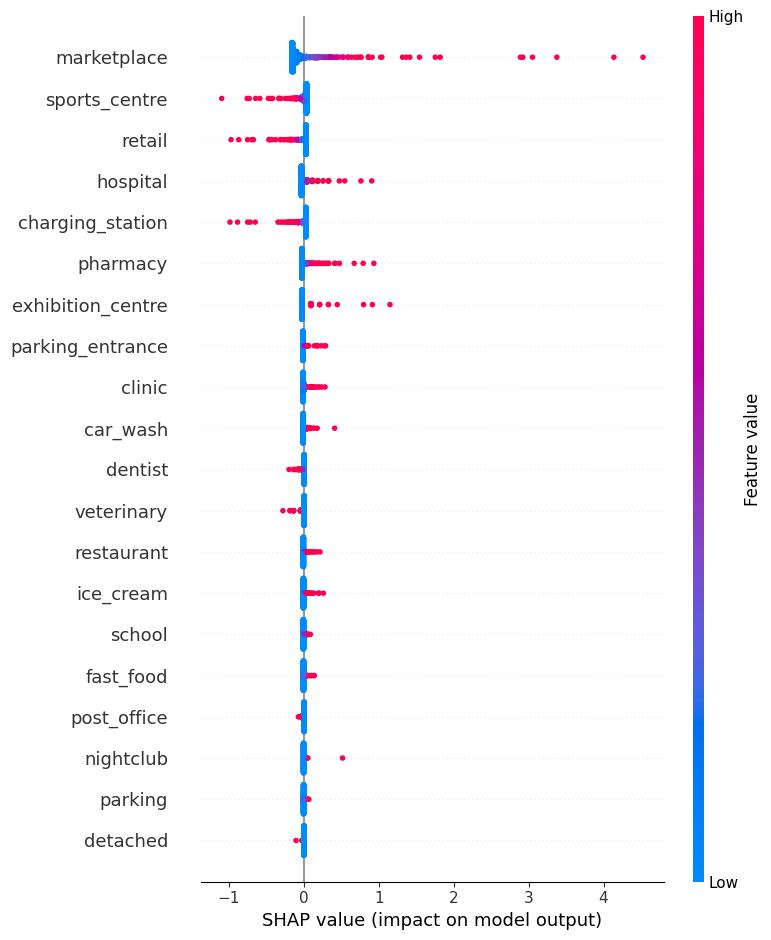

In [27]:
import shap
# 使用 SHAP 解釋模型
explainer = shap.LinearExplainer(svr, X_yixing_input)

# 計算 SHAP 值
# shap_values_train = explainer.shap_values(X_train_reguli)
shap_values_test = explainer.shap_values(X_yixing_input)

feature_names = X_yixing.columns
shap.summary_plot(shap_values_test, X_yixing_input,feature_names, max_display=20)